In [ ]:
! sudo apt-get install -y fonts-nanum
!sudo fc-cache -fv
!rm ~/.cache/matplotlib-rf

import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
fm.fontManager.addfont('/usr/share/fonts/truetype/nanum/NanumGothic.ttf')
plt.rcParams['font.family'] = 'NanumGothic'

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
fonts-nanum is already the newest version (20200506-1).
0 upgraded, 0 newly installed, 0 to remove and 41 not upgraded.
/usr/share/fonts: caching, new cache contents: 0 fonts, 1 dirs
/usr/share/fonts/truetype: caching, new cache contents: 0 fonts, 3 dirs
/usr/share/fonts/truetype/humor-sans: caching, new cache contents: 1 fonts, 0 dirs
/usr/share/fonts/truetype/liberation: caching, new cache contents: 16 fonts, 0 dirs
/usr/share/fonts/truetype/nanum: caching, new cache contents: 12 fonts, 0 dirs
/usr/local/share/fonts: caching, new cache contents: 0 fonts, 0 dirs
/root/.local/share/fonts: skipping, no such directory
/root/.fonts: skipping, no such directory
/usr/share/fonts/truetype: skipping, looped directory detected
/usr/share/fonts/truetype/humor-sans: skipping, looped directory detected
/usr/share/fonts/truetype/liberation: skipping, looped directory detected
/usr/share/fonts/truetype/

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm

In [ ]:
# 1. 데이터 로드 및 전처리
df = pd.read_csv("South_korea_visitor(19_24) - Total_19_24.csv")

#준협님 코드 사용!
cols_to_convert = df.columns.difference(['date', 'nation'])
for col in cols_to_convert:
    df[col] = pd.to_numeric(df[col].astype(str).str.replace(',', '').str.replace('-', '0').str.replace('nan', '0'), errors='coerce').fillna(0).astype(int)
df['date'] = pd.to_datetime(df['date'])
df['year'] = df['date'].dt.year

# 2. 홍콩 데이터 필터링
df_hk = df[df['nation'] == 'Hong Kong'].copy()

# 3. 연령대 특징 추출 및 매핑 정의
age_features = ['age0-20', 'age21-30', 'age31-40', 'age41-50', 'age51-60', 'age61']
age_group_map = {
    'age0-20_ratio': '0-20세', 'age21-30_ratio': '21-30세', 'age31-40_ratio': '31-40세',
    'age41-50_ratio': '41-50세', 'age51-60_ratio': '51-60세', 'age61_ratio': '61세 이상',
}
age_order = list(age_group_map.values())

파이차트 생성

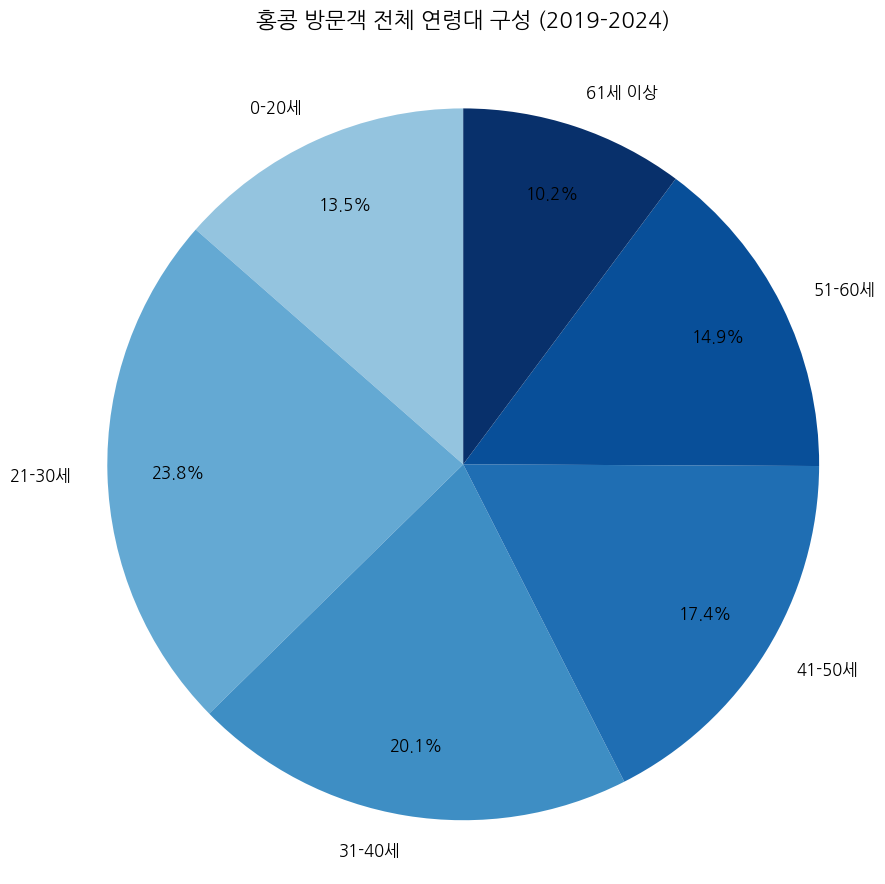

In [ ]:
# 4. 전체 기간 (2019-2024) 연령 구성 비율 계산
df_overall_hk = df_hk[age_features].sum().reset_index()
df_overall_hk.columns = ['Age_Group', 'Total_Count']
overall_total = df_overall_hk['Total_Count'].sum()
df_overall_hk['Proportion'] = df_overall_hk['Total_Count'] / overall_total

# 레이블 설정
df_overall_hk['Age_Group_Label'] = df_overall_hk['Age_Group'].map(lambda x: age_group_map[f'{x}_ratio'])
labels = df_overall_hk['Age_Group_Label']
proportions = df_overall_hk['Proportion']

# 파이 차트 생성
colors = plt.cm.Blues(np.linspace(0.4, 1, len(labels)))
plt.figure(figsize=(9, 9))
plt.pie(
    proportions,
    labels=labels,
    autopct='%1.1f%%',
    startangle=90,
    pctdistance=0.8,
    textprops={'fontsize': 12, 'color': 'black'},
    colors=colors
)

plt.title('홍콩 방문객 전체 연령대 구성 (2019-2024)', fontsize=16, pad=20)
plt.axis('equal')
plt.tight_layout()

```
홍콩 방문객 연령대 시각화 결과 (2019-2024)
1. 파이 그래프 (전체 기간 연령대 구성)

핵심 비중: **21~30세 (23.8%)**와 **31~40세 (20.1%)**가 전체 방문객의 **43.9%**를 차지하며, 20~40대가 홍콩 시장의 주요 축.

시사점: 마케팅 자원의 절반 가까이를 젊은층 및 초기 중장년층에 집중할 것

선 그래프

In [ ]:
# 5. 연도별 집계 및 비율 계산
df_yearly_hk = df_hk.groupby('year')[['visitor'] + age_features].sum().reset_index()
df_yearly_hk['total_age_sum'] = df_yearly_hk[age_features].sum(axis=1)

ratio_features = [f'{col}_ratio' for col in age_features]
for col in age_features:
    df_yearly_hk[f'{col}_ratio'] = np.where(df_yearly_hk['total_age_sum'] > 0, df_yearly_hk[col] / df_yearly_hk['total_age_sum'], 0)

# 시각화를 위한 데이터프레임 melt
df_ratios_hk = df_yearly_hk[['year'] + ratio_features].copy()
df_viz_hk = df_ratios_hk.melt(
    id_vars='year',
    value_vars=ratio_features,
    var_name='Age_Feature',
    value_name='Ratio'
)
df_viz_hk['Age_Group_Label'] = df_viz_hk['Age_Feature'].map(age_group_map)

In [ ]:
# 선 그래프 생성
plt.figure(figsize=(12, 7))

# Blues colormap에서 6개의 뚜렷한 파란색 톤을 가져옵니다.
color_map = plt.cm.get_cmap('Blues')
num_groups = len(age_order)
# 0.4부터 1.0 범위 내에서 색상 선택 (너무 밝은 색 피하기)
colors = [color_map(i / (num_groups - 1) * 0.6 + 0.4) for i in range(num_groups)]

for i, age_label in enumerate(age_order):
    subset = df_viz_hk[df_viz_hk['Age_Group_Label'] == age_label]
    plt.plot(subset['year'], subset['Ratio'], marker='o', label=age_label, color=colors[i])

plt.title('홍콩 방문객 연도별 연령대 구성 비율 변화 (2019-2024)', fontsize=16, pad=20)
plt.xlabel('연도 (Year)', fontsize=12)
plt.ylabel('비율 (Proportion)', fontsize=12)

# Y축 포맷팅 (백분율)
y_ticks = plt.gca().get_yticks()
plt.gca().set_yticklabels(['{:,.0%}'.format(x) for x in y_ticks])
plt.xticks(df_yearly_hk['year'].unique())
plt.grid(True, linestyle='--', alpha=0.7)
plt.legend(title='연령대', loc='upper left', bbox_to_anchor=(1, 1))

plt.tight_layout()

/tmp/ipython-input-2262726729.py:5: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  color_map = plt.cm.get_cmap('Blues')
/tmp/ipython-input-2262726729.py:20: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  plt.gca().set_yticklabels(['{:,.0%}'.format(x) for x in y_ticks])


```
2. 선 그래프 (연도별 연령대 구성 변화)
선 그래프는 연도별로 각 연령대의 비중이 어떻게 변화했는지 추이를 보여줍니다.

[20~30대 비중의 회복]
21~30세와 31~40세 라인은 2021년과 2022년 팬데믹 기간 동안 급격히 변동했으나, 2023년 이후 2019년 수준을 회복하거나 그 이상으로 비중이 상승하는 경향을 보임. 이는 홍콩 시장이 **젊은층의 개별 여행(FIT)**을 중심으로 운영 중임을 알 수 있음!


[고연령층의 상대적 변화]
51~60세나 61세 이상의 라인은 팬데믹 기간 중 방문객 수가 적었을 때 상대적 비중이 높아졌다가, 시장이 회복되면서 다시 비중이 감소하는 패턴보임.
일반적인 관광 목적으로는 젊은층이 더 빨리 복귀했음.


1. 연령대별 '여행 목적' 교차 분석

이들이 왜 한국에 오는걸까? -> 목적에 맞춰서 마케팅 전략 짜기

In [ ]:
#홍콩 데이터 필터링 (2019-2024 전체 기간)
df_hk = df[df['nation'] == 'Hong Kong'].copy()

# 전체 기간 총합 계산
hk_totals = df_hk.sum(numeric_only=True)

# 주요 지표 계산을 위한 컬럼 정의
age_features = ['age0-20', 'age21-30', 'age31-40', 'age41-50', 'age51-60', 'age61']
purpose_features = ['tourism', 'business', 'official affairs', 'studying', 'others']
gender_features = ['male', 'female']

# 비승무원(Non-Crew) 방문객 총합 (성별 합산 사용)
total_non_crew = hk_totals[gender_features].sum()

# 목적 비율 분석

In [ ]:
# '비관광' 목적 (business, official affairs, studying, others) 총합 계산
non_tourism_count = hk_totals[['business', 'official affairs', 'studying', 'others']].sum()

# 목적별 전체 비율 계산
tourism_ratio = hk_totals['tourism'] / total_non_crew
non_tourism_ratio = non_tourism_count / total_non_crew

In [ ]:
print(non_tourism_count)
print(tourism_ratio)
print(non_tourism_ratio)

34878
0.9899344308615402
0.01932336638106556


# 성별 비율 분석

In [ ]:
# 성별 전체 비율 계산
female_ratio = hk_totals['female'] / total_non_crew
male_ratio = hk_totals['male'] / total_non_crew

# 21-30세 비중 (핵심 연령대 확인용)
age21_30_count = hk_totals['age21-30']
total_age_sum = hk_totals[age_features].sum()
age21_30_ratio_overall = age21_30_count / total_age_sum

In [ ]:
results_dict = {
    'Metric': [
        'Total Non-Crew Visitors (2019-2024)',
        'Age 21-30 Ratio (Overall Age Sum)',
        'Female Ratio (Overall)',
        'Male Ratio (Overall)',
        'Tourism Ratio (Overall)',
        'Non-Tourism Ratio (Overall)'
    ],
    'Value': [
        total_non_crew,
        age21_30_ratio_overall,
        female_ratio,
        male_ratio,
        tourism_ratio,
        non_tourism_ratio
    ]
}

df_results = pd.DataFrame(results_dict)

# 비율 값 포맷팅
for index, row in df_results.iterrows():
    if 'Ratio' in row['Metric']:
        df_results.loc[index, 'Value_Formatted'] = f"{row['Value'] * 100:.1f}%"
    else:
        df_results.loc[index, 'Value_Formatted'] = f"{row['Value']:,}"

df_display = df_results[['Metric', 'Value_Formatted']].rename(columns={'Value_Formatted': 'Result'})

print("--- 홍콩 방문객 심층 타겟팅 분석 결과 (2019-2024 통합) ---")
print(df_display.to_markdown(index=False))

--- 홍콩 방문객 심층 타겟팅 분석 결과 (2019-2024 통합) ---
| Metric                              | Result      |
|:------------------------------------|:------------|
| Total Non-Crew Visitors (2019-2024) | 1,804,965.0 |
| Age 21-30 Ratio (Overall Age Sum)   | 23.8%       |
| Female Ratio (Overall)              | 67.2%       |
| Male Ratio (Overall)                | 32.8%       |
| Tourism Ratio (Overall)             | 99.0%       |
| Non-Tourism Ratio (Overall)         | 1.9%        |


```
[인사이트]

홍콩 방문객 심층 타겟팅 핵심 인사이트(2019-2024통합)

1. 시장 성격 : 순서 관광 주도 시장
 Tourism Ratio : 99.0%
 Non-Tourism Ratio:1.9%  

 [홍콩 시장은 '관광' 이외의 요인에 의해 흔들리지 않는 견고한 레저 시장이므로, 모든 마케팅 자원과 상품 개발은 체험 및 재미에 초점]


2. 코어 타겟: 압도적인 20~30대 여성
Female Ratio : 67.2% (성별 불균형이 매우 심각. 여성 방문객이 남성의 2배 이상.)
Age 21-30 Ratio : 23.8%

[홍콩 시장의 코어 타겟: 0~30대 여성 관광객 -> 경험 소비 주도층 K-컬처와 트렌드 맞춤 마케팅 전략]

```
마케팅 예산 분배를 위해서 ++ 외국인들 소비 관련 통계 자료 찾아봐도 좋을 듯


1. 상품/콘텐츠 전략: '여성-MZ세대-인증샷'에 올인 📱
맞춤 상품: 성별과 연령을 고려하여 K-팝, K-뷰티, 패션, 트렌디한 카페/미식 탐방 등 여성 20~30대가 주도하는 체험형 상품

소셜 콘텐츠 최적화: 여행 후 인스타그램, 틱톡 등에 공유할 수 있는 '인증샷 명소' 발굴 및 홍보에 마케팅 예산의 대부분을 투입할 것. 상품 기획 단계부터 **'SNS 공유 가치(Shareability)'**를 최우선 요소로 고려

2. 채널 전략: 디지털 및 인플루언서 중심 🎙️
채널 집중: 67.2%의 여성, 특히 젊은층을 공략하기 위해 전통적인 광고 채널 대신 인스타그램, 샤오훙슈(중화권), 유튜브 등 시각 기반 디지털 플랫폼에 마케팅 예산 집중

캠페인 방향: 홍콩의 영향력 있는 여성 인플루언서 및 K-컬처 팬덤을 활용한 콜라보레이션 캠페인을 통해 바이럴 효과를 극대화 ++ 틱톡 쪽 노려도 재밌을 듯

3. 예산 배분 원칙: 고수익 코어 타겟 집중 💰
예산 배분: 전체 홍콩 시장 마케팅 예산의 **최소 70~80%**를 이 핵심 타겟(20~30대 여성)을 직접 유인할 수 있는 프로그램과 콘텐츠에 배분하는 것이 가장 효율적

비즈니스 포기: 비즈니스/유학 등 비관광 목적 방문객 유치를 위한 인프라나 홍보 활동에는 예산을 거의 투입하지 않아야 할 듯

-------------